In [ ]:
import pandas as pd
import math
import numpy as np
import random
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import time
from scipy import stats
from time import time
import matplotlib.pyplot as plt
import itertools
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
import warnings
from io import BytesIO
from zipfile import ZipFile
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
data = pd.read_csv('/data/sample_data.csv')

In [ ]:
data_url = 'http://files.grouplens.org/datasets/movielens/ml-latest.zip'
res = requests.get(data_url)
file = ZipFile(BytesIO(res.content)).open('ml-latest/movies.csv')
movies = pd.read_csv(file)

In [ ]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed)
58094,193878,Les tribulations d'une caissière (2011),Comedy
58095,193880,Her Name Was Mumu (2016),Drama
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi


In [ ]:
genres = []
for val in movies['genres']:
  genres.extend(val.split("|"))

final_genres = list(set(genres))
print("The number of genres in our dataset are", len(final_genres))

The number of genres in our dataset are 20


In [ ]:
movies['genres'] = movies['genres'].apply(lambda val:val.split("|"))

In [ ]:
file2 = ZipFile(BytesIO(res.content)).open('ml-latest/tags.csv')
tags = pd.read_csv(file2)

,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195
...,...,...,...,...
1108992,283206,73017,fun,1264379059
1108993,283206,73017,homoerotic subtext,1264379058
1108994,283206,73017,pacing,1264379058
1108995,283206,73017,plot,1264379058


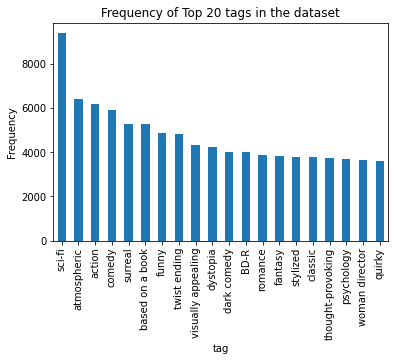

In [ ]:
frequencies = tags.groupby("tag")['movieId'].count()
frequencies = frequencies.sort_values(ascending=False)
top_20  = frequencies[:20]
top_20.plot.bar()
plt.title("Frequency of Top 20 tags in the dataset")
plt.ylabel("Frequency")
plt.show()

In [ ]:
movie_freq = tags.groupby('movieId', as_index=False).agg(num_tags=('tag','count'))
movie_freq  = movie_freq [(np.abs(stats.zscore(movie_freq )) < 3).all(axis=1)]
user_freq = tags.groupby('userId', as_index=False).agg(num_tags=('tag','count'))
user_freq = user_freq [(np.abs(stats.zscore(user_freq )) < 3).all(axis=1)]

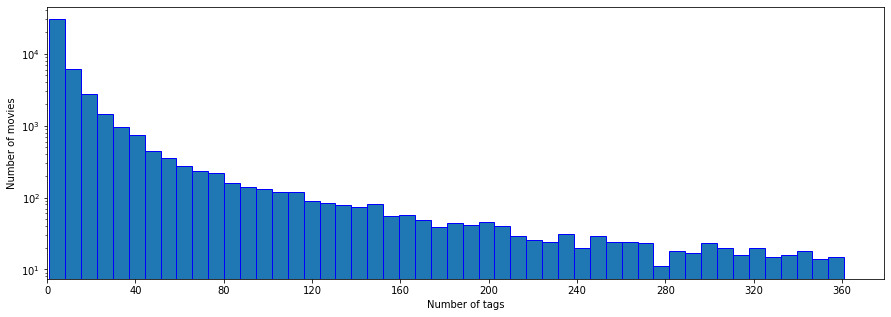

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(movie_freq['num_tags'], bins=50, edgecolor='b', log=True)
plt.xlim(0,)
plt.xticks(np.arange(0,400,40))
plt.xlabel('Number of tags')
plt.ylabel('Number of movies')
plt.show()

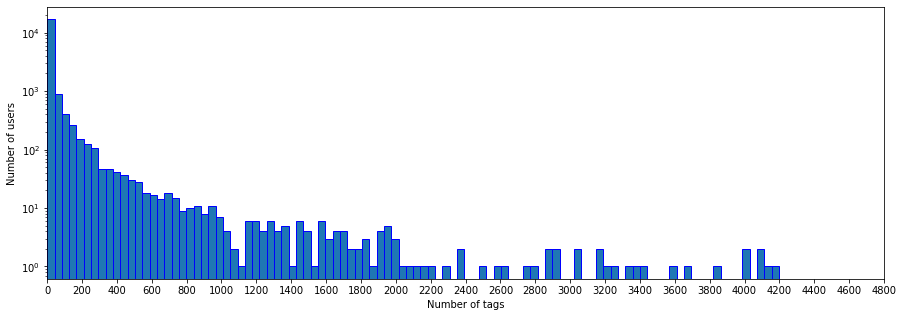

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(user_freq['num_tags'], bins=100, edgecolor='b', log=True)
plt.xlim(0,)
plt.xticks(np.arange(0,5000,200))
plt.xlabel('Number of tags')
plt.ylabel('Number of users')
plt.show()

In [ ]:
tag = tags.groupby(['movieId'])['tag'].apply(list).reset_index(name='tags')
tag

,movieId,tags
0,1,"[animated, buddy movie, Cartoon, cgi, comedy, ..."
1,2,"[fantasy, adapted from:book, animals, bad cgi,..."
2,3,"[moldy, old, Ann Margaret, Burgess Meredith, D..."
3,4,"[characters, girl movie, characters, chick fli..."
4,5,"[steve martin, steve martin, pregnancy, remake..."
...,...,...
45976,193761,"[concert, hostage, kidnapping, opera singer, r..."
45977,193811,"[doppelganger, Julie Delpy]"
45978,193837,"[aliens, anime, cat, space marines, virus]"
45979,193864,"[Alfredo Landa, anticonception, comic, family,..."


CONTENT BASED ITEM-ITEM RECOMMENDATION MODEL 




In [ ]:
metadata = pd.merge(movies,tag,on = "movieId",how='inner',right_index=False)
metadata['content'] = metadata['genres'] + metadata['tags']

In [ ]:
def stem_content(content):
  porter = PorterStemmer()
  st=[]
  for word in content:
    st.append(porter.stem(str(word)))
  return st

In [ ]:
a = metadata.loc[:,'content']

list_=[]
for i in range(len(a)):
    list_.append(stem_content(a[i]))
metadata['content'] = list_

In [ ]:
metadata['content'] = [','.join(map(str, l)) for l in metadata['content']]
metadata

,movieId,title,genres,tags,content
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[animated, buddy movie, Cartoon, cgi, comedy, ...","adventur,anim,children,comedi,fantasi,anim,bud..."
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]","[fantasy, adapted from:book, animals, bad cgi,...","adventur,children,fantasi,fantasi,adapted from..."
2,3,Grumpier Old Men (1995),"[Comedy, Romance]","[moldy, old, Ann Margaret, Burgess Meredith, D...","comedi,romanc,moldi,old,ann margaret,burgess m..."
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]","[characters, girl movie, characters, chick fli...","comedi,drama,romanc,charact,girl movi,charact,..."
4,5,Father of the Bride Part II (1995),[Comedy],"[steve martin, steve martin, pregnancy, remake...","comedi,steve martin,steve martin,pregnanc,rema..."
...,...,...,...,...,...
45976,193761,Bel Canto (2018),"[Drama, Thriller]","[concert, hostage, kidnapping, opera singer, r...","drama,thriller,concert,hostag,kidnap,opera sin..."
45977,193811,Burning Shadow (2018),[Thriller],"[doppelganger, Julie Delpy]","thriller,doppelgang,julie delpi"
45978,193837,Lily C.A.T. (1987),"[Animation, Horror, Sci-Fi]","[aliens, anime, cat, space marines, virus]","anim,horror,sci-fi,alien,anim,cat,space marin,..."
45979,193864,No somos de piedra (1968),[Comedy],"[Alfredo Landa, anticonception, comic, family,...","comedi,alfredo landa,anticoncept,comic,famili,..."


In [ ]:
from bs4 import BeautifulSoup
import re
def cleanText(text):
    text = re.sub('\n','', text)
    text = re.sub(',',' ', text)
    text = re.sub('__',' ', text)
    
    text = re.sub(':',' ', text)
    text = text.lower()  # Remove caps
    text = text.strip()
    return text

a = metadata.loc[:,'content']

clean=[]
for i in range(len(a)):
    clean.append(cleanText(a[i]))
metadata['movie_content']=clean

In [ ]:
data1 = list(metadata['movie_content'])
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data1)]

max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

start_time = time()
for epoch in range(max_epochs):
    #print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    
    # decrease the learning rate
    model.alpha -= 0.0004
    
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

end_time = time()
print('Execution time:'+str((end_time-start_time)//60)+' min, '+str(round((end_time-start_time)%60,1))+' seconds')


In [ ]:
model.save("/data/d2vmovies.model")
print("Model Saved")

Model Saved


In [ ]:
downloaded.GetContentFile('d2vmovies.model')  
model = Doc2Vec.load("/data/d2vmovies.model")
print("Model Loaded")

Model Loaded


In [ ]:
similar_doc_test = model.docvecs.most_similar('1')
print(similar_doc_test)

[('8863', 0.8765408992767334), ('10192', 0.875840425491333), ('12769', 0.8525252938270569), ('5438', 0.8506702184677124), ('8998', 0.8333911895751953), ('12806', 0.8229997158050537), ('10352', 0.8120715022087097), ('11390', 0.8009260892868042), ('7412', 0.7934632301330566), ('12352', 0.7876929044723511)]


In [ ]:
def similar_movies(key,k): # key is title of Movie and n is the number of similar movie recommendations we need
    
    key_index = metadata.index[metadata['title'] == key]
    similar_doc_test = model.docvecs.most_similar(key_index,topn=k)
    movie = []

    for i in range(len(similar_doc_test)):

        score = similar_doc_test[i][1]
        ind = int(similar_doc_test[i][0])
        key_value = metadata['title'][ind]
        movie.append((key_value,score))
        
    return movie

In [ ]:
movie_recommendations = {}

In [ ]:
movie_recommendations["Star Wars: Episode IV - A New Hope (1977)"] =  [tuple1[0] for tuple1 in similar_movies("Star Wars: Episode IV - A New Hope (1977)",5)]
movie_recommendations["Die Hard: With a Vengeance (1995)"] = [tuple1[0] for tuple1 in similar_movies("Die Hard: With a Vengeance (1995)",5)]
movie_recommendations["Batman Forever (1995)"] =  [tuple1[0] for tuple1 in similar_movies("Batman Forever (1995)",5)]
movie_recommendations["Usual Suspects, The (1995)"] = [tuple1[0] for tuple1 in similar_movies("Usual Suspects, The (1995)",5)]
movie_recommendations["Schindler's List (1993)"] = [tuple1[0] for tuple1 in similar_movies("Schindler's List (1993)",5)]
movie_recommendations["Mortal Kombat (1995)"] = [tuple1[0] for tuple1 in similar_movies("Mortal Kombat (1995)",5)]
movie_recommendations["The Hunger Games: Mockingjay - Part 1 (2014)"] = [tuple1[0] for tuple1 in similar_movies("The Hunger Games: Mockingjay - Part 1 (2014)",5)]

In [ ]:
recommendations = pd.DataFrame.from_dict(movie_recommendations, orient ='index')
recommendations.columns = ['Movie 1','Movie 2','Movie 3','Movie 4','Movie 5']
recommendations

,Movie 1,Movie 2,Movie 3,Movie 4,Movie 5
Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode VI - Return of the Jedi (1983),Star Wars: Episode I - The Phantom Menace (1999),Star Wars: Episode II - Attack of the Clones (...,Star Wars: Episode V - The Empire Strikes Back...,Star Wars: Episode III - Revenge of the Sith (...
Batman Forever (1995),Ant-Man and the Wasp (2018),Spider-Man 3 (2007),Fantastic Four: Rise of the Silver Surfer (2007),"Amazing Spider-Man, The (2012)",Iron Man 3 (2013)
"Usual Suspects, The (1995)","Departed, The (2006)",L.A. Confidential (1997),Inside Man (2006),"Ghost Writer, The (2010)",Nick of Time (1995)
The Hunger Games: Mockingjay - Part 1 (2014),Allegiant: Part 1 (2016),The Hunger Games: Catching Fire (2013),Insurgent (2015),Divergent (2014),FAQ: Frequently Asked Questions (2004)


In [ ]:
similar_movies("The Hunger Games: Mockingjay - Part 1 (2014)",10)

[('Allegiant: Part 1 (2016)', 0.8808690905570984),
 ('The Hunger Games: Catching Fire (2013)', 0.8771207928657532),
 ('Insurgent (2015)', 0.8687823414802551),
 ('Divergent (2014)', 0.8524252772331238),
 ('FAQ: Frequently Asked Questions (2004)', 0.8320668339729309),
 ('The Hunger Games (2012)', 0.8226839303970337),
 ('Aeon Flux (2005)', 0.8107877969741821),
 ('Hulk (2003)', 0.7983793020248413),
 ('Ultraviolet (2006)', 0.7959374189376831),
 ('V for Vendetta (2006)', 0.7780249118804932)]